#  PROJETO LANDSLIDE


**Objetivo**

Predição de deslizamentos de terras em áreas de encosta (landslides), dado um conjunto de características do ambiente, as tais features, captadas por dispositivos.

**A necessidade**

São Paulo sofre cerca de 200 deslizamentos de terra letais por ano. Um sistema que prevê e alerta sobre deslizamentos de terra é essencial para salvar vidas.


**Input\features potenciais**

+ medições de alta-frequência do trabalho de flexão externa
+ pressão da água nos poros em várias profundidades
+ pressão horizontal do solo
+ técnicas avançadas de monitoramento de superfície (não sei do que se trata)
+ índice pluviométrico
+ emissões acústicas
+ frequência de “rockfall”
+ indicadores que sugerem mudanças estruturais na região
+ deslocamento de inclinações e derivados
+ dados geo-espaciais (topográficos, geológicos, geotécnicos)  
+ controles como tipo de vegetação, distância de rodovias ou contenções artificiais


**Output da predição**

Uma pontuação de "deslizamento" ("landslide score"), que reflete a probabilidade de um deslizamento de terra em uma região específica em um intervalo de tempo predito específico.




**Escolha do tipo do Modelo**

**Classificação vs Regressão** 

Nossa escolha é de um modelo de regressão em vez de um modelo de classificação. Em um problema de classificação, está se prevendo a classe correta ou não. Nós não queríamos uma métrica simples de acerto ou falha, mas um valor probabilistico (0 até 1) que se pudesse plotar.

A regressão logistica foi escolhida para fornecer uma previsão de valor e, a partir daí, o "landslide score" será calculado e mostrado aos usuários.

**Os modelos opcionais**

+ Logistic Regression (Baseline model)
+ Randon Forest
+ RNN
+ XGBoost
+ SVM (TBD...)
+ CNN (TBD...)

**As métricas opcionais**

+ MSE (Mean Square Error)
+ RMSE (Root Mean Square Error)
+ Métrica "tailor made" (TBD...)



# Coleta dos Dados

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# import missingno as msno

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

In [2]:
ls = pd.read_csv(r'ls_demo.csv')
ls.head()

,datetime,Data,Hora,LS,TEMP,UR
0,10/27/2016 1:00,27/10/2016,1:00,0,20.6,90.0
1,10/27/2016 2:00,27/10/2016,2:00,0,20.4,90.0
2,10/27/2016 3:00,27/10/2016,3:00,0,20.1,93.0
3,10/27/2016 4:00,27/10/2016,4:00,0,21.0,86.0
4,10/27/2016 5:00,27/10/2016,5:00,0,21.0,83.0


# Tratamento dos Dados

## Verificação de dados faltantes

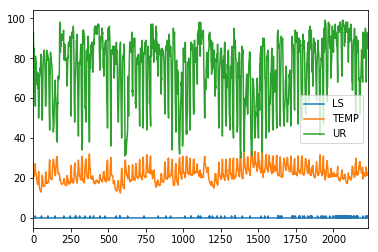

In [3]:
ls.plot();

## Preenchendo os dados faltantes (com MA)

In [4]:
ls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2231 entries, 0 to 2230
Data columns (total 6 columns):
datetime    2231 non-null object
Data        2231 non-null object
Hora        2231 non-null object
LS          2231 non-null int64
TEMP        2225 non-null float64
UR          2225 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 104.7+ KB


In [5]:
ls.fillna(value=ls.TEMP.rolling(7*24, min_periods=1,).mean(), inplace=True)

In [6]:
ls.fillna(value=ls.UR.rolling(7*24, min_periods=1,).mean(), inplace=True)

In [7]:
ls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2231 entries, 0 to 2230
Data columns (total 6 columns):
datetime    2231 non-null object
Data        2231 non-null object
Hora        2231 non-null object
LS          2231 non-null int64
TEMP        2225 non-null float64
UR          2225 non-null float64
dtypes: float64(2), int64(1), object(3)
memory usage: 104.7+ KB


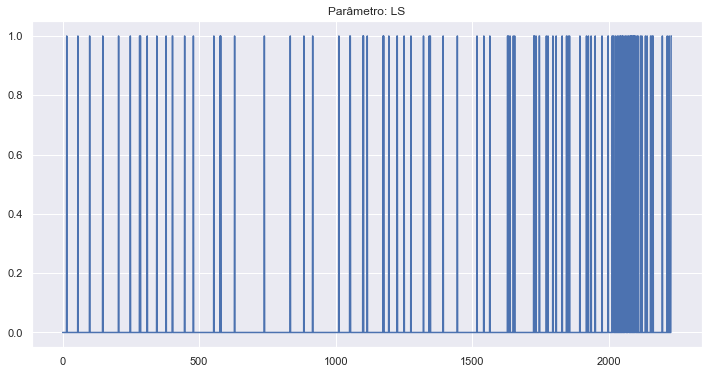

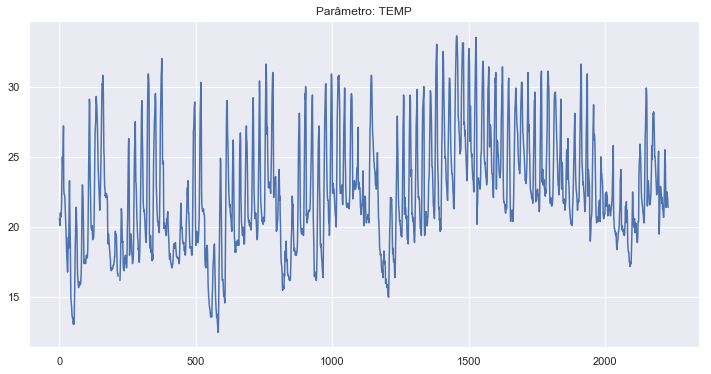

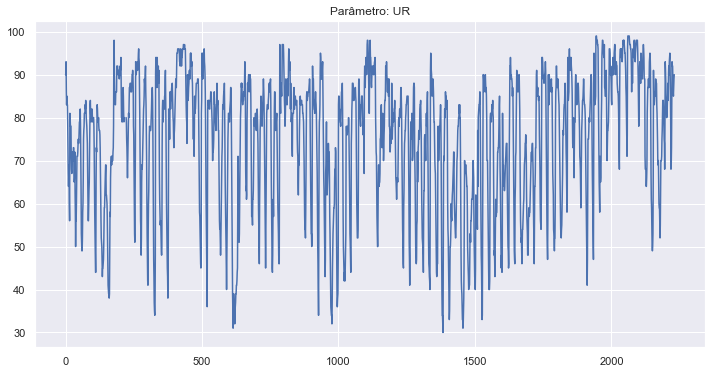

In [8]:
sns.set()

for p in list(ls.drop(['datetime','Data', 'Hora'],axis=1)):
    plt.figure(figsize=(12,6))
    plt.title('Parâmetro: '+str(p))
    plt.plot(ls[p])
    plt.grid(True)
    plt.show()

# EDA

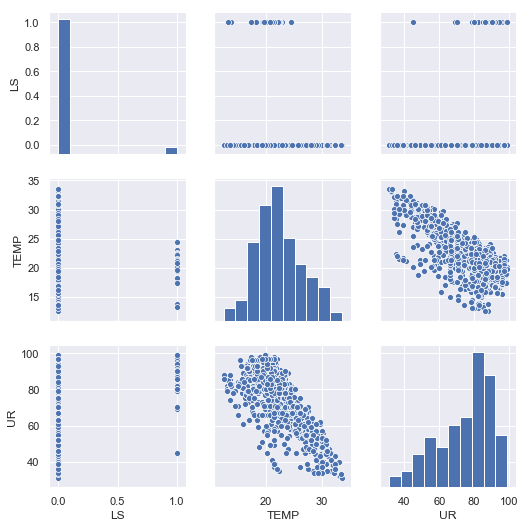

In [9]:
sns.pairplot(ls.drop(['Data','Hora'],axis=1).sample(1000));

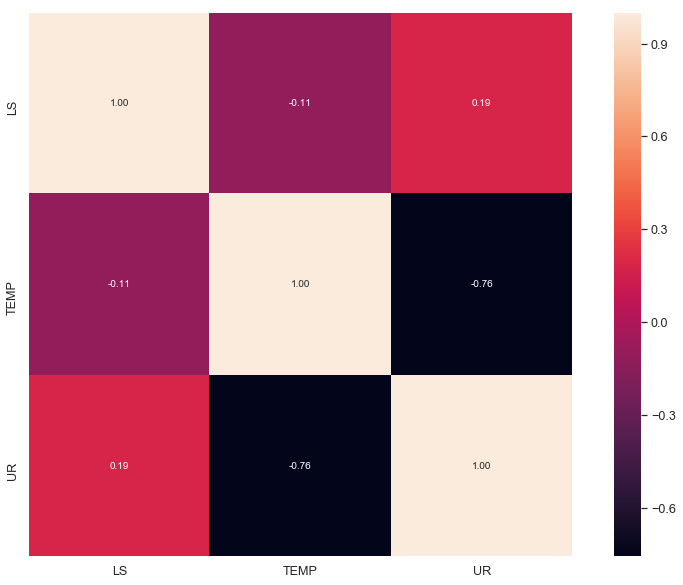

In [10]:
corrmat = ls.corr()
sns.set(font_scale=1.15)
f, ax = plt.subplots(figsize=(15, 10))
hm = sns.heatmap(corrmat, 
                 cbar=True, # formatando a barra lateral de cores para o heatmap
                 annot=True, 
                 square=True, 
                 fmt='.2f', 
                 annot_kws={'size': 10}, 
                 yticklabels=corrmat.columns, 
                 xticklabels=corrmat.columns)

In [11]:
ls = ls.dropna(axis=0)

In [12]:
ls.shape

(2225, 6)

In [13]:
ls.head(3)

,datetime,Data,Hora,LS,TEMP,UR
0,10/27/2016 1:00,27/10/2016,1:00,0,20.6,90.0
1,10/27/2016 2:00,27/10/2016,2:00,0,20.4,90.0
2,10/27/2016 3:00,27/10/2016,3:00,0,20.1,93.0


# Logistic Regression as a baseline

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

In [15]:
X = ls.drop(['datetime','Data','Hora','LS'], axis=1)
y = ls['LS']

In [16]:
def ts_train_test_split(X, y, test_size):
   
 # Perform train-test split with respect to time series structure
    
 # get the index after which test set starts

    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

## Fit

In [17]:
X_train, X_test, y_train, y_test = ts_train_test_split(X, y, test_size=0.3)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1557, 2) (1557,) (668, 2) (668,)


In [18]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

## Predict

In [19]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.90


## Matriz da Cofusão

In [20]:
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore")

confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[601   0]
 [ 67   0]]


In [21]:
# tp: True Positive
# fp: False Positive
# fn: False Negative
# tn: True Negative

tn, fp, fn, tp = confusion_matrix.ravel()

tn, fp, fn, tp

(601, 0, 67, 0)

In [22]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95       601
           1       0.00      0.00      0.00        67

    accuracy                           0.90       668
   macro avg       0.45      0.50      0.47       668
weighted avg       0.81      0.90      0.85       668



 ## ROC

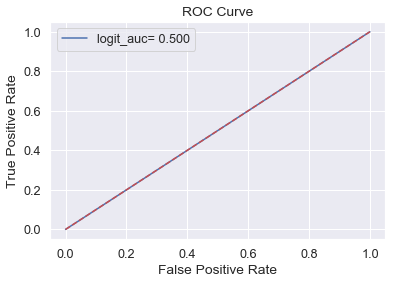

In [23]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr,tpr,thresholds = roc_curve(y_test.values,logreg.predict(X_test))

logit_auc = roc_auc_score(y_test.values,logreg.predict(X_test))

plt.plot(fpr,tpr,label='logit_auc= %0.3f'%logit_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')

## Forecast

In [24]:
ls.set_index('datetime', inplace=True)
ls.drop(['Data', 'Hora'], axis=1, inplace=True)
ls_future = pd.DataFrame(index=pd.date_range(start='2017-01-28', end='2017-02-01', freq='H'), columns=ls.columns).fillna(0)
ls_total = ls.append(ls_future)

In [25]:
print(ls.shape, ls_future.shape, ls_total.shape)

(2225, 3) (97, 3) (2322, 3)


In [26]:
ls_total.tail()

,LS,TEMP,UR
2017-01-31 20:00:00,0,0.0,0.0
2017-01-31 21:00:00,0,0.0,0.0
2017-01-31 22:00:00,0,0.0,0.0
2017-01-31 23:00:00,0,0.0,0.0
2017-02-01 00:00:00,0,0.0,0.0


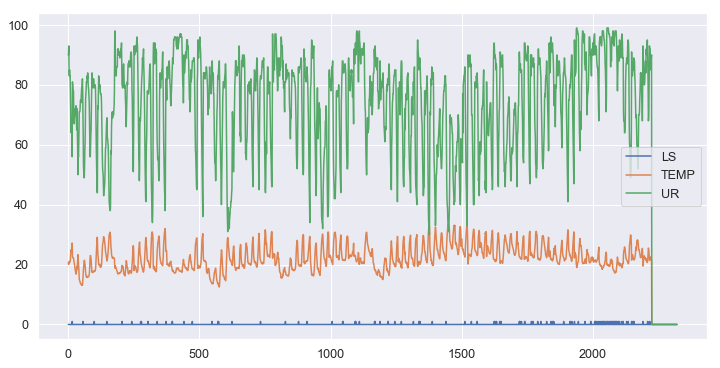

In [27]:
plt.figure(figsize=(12,6))
plt.plot(ls_total.values)
plt.legend(ls.columns, loc='best');